## Attributes Classificator

In this notebook I will try to classify all the attributes present in a face.
This could be useful to use the attributes as condition in input of conditional models.

A first attempt was made trying to train from scratch a VGGNetLike model. Unfortunately the accuracy remained very low. I think I will try to switch to transfer learning on a pretrained model. 

In [1]:
from classes.Architectures import VGGNetLike
import numpy as np
import pandas as pd
from os.path import join as opj

import os

import tensorflow as tf
from tensorflow import keras
import numpy as np
import wandb
from wandb.keras import WandbCallback
from imutils import paths
from tensorflow.data import AUTOTUNE
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante (use `wandb login --relogin` to force relogin)


True

In [2]:
images_dir=r"/home/matteo/NeuroGEN/Dataset/Img/img_align_celeba"
anno_dir=r"/home/matteo/NeuroGEN/Dataset/Anno/list_attr_celeba.csv"
#other important definitions

EPOCHS=50
BS=256
INIT_LR=1e-4

config={}
config["epochs"]=EPOCHS
config["BS"]=BS
config["init_lr"]=INIT_LR

wandb.init(project="TorVergataExperiment-Generative",config=config,name="CelebA_Attribute_Prediciton")

## Load data and indices

In [3]:
df=pd.read_csv(anno_dir,sep=",")

In [4]:
@tf.function
def load_images(imagePath,attr):

    #attr=df.iloc[idx].drop("image_id",axis=1).values
    # read the image from disk, decode it, resize it, and scale the
    # pixels intensities to the range [0, 1]
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224)) / 255.0

    #eventually load other information like attributes here
    
    # return the image and the extra info
    
    
    return image,attr

In [5]:
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(images_dir))


train_len=int(0.8*len(imagePaths))
val_len=int(0.1*len(imagePaths))
test_len=int(0.1*len(imagePaths))

train_imgs=imagePaths[:train_len]                                #      80% for training
val_imgs=imagePaths[train_len:train_len+val_len]                 #      10% for validation
test_imgs=imagePaths[train_len+val_len:]                         #      10% for testing

train_idxs=[int(i.split("/")[-1].split(".jpg")[0])-1 for i in train_imgs]
val_idxs=[int(i.split("/")[-1].split(".jpg")[0])-1 for i in val_imgs]
test_idxs=[int(i.split("/")[-1].split(".jpg")[0])-1 for i in test_imgs]

train_attr=[df.iloc[idx].drop("image_id").values for idx in train_idxs]
val_attr=[df.iloc[idx].drop("image_id").values for idx in val_idxs]
test_attr=[df.iloc[idx].drop("image_id").values for idx in test_idxs]


print(f"[TRAINING]\t {len(train_imgs)}\n[VALIDATION]\t {len(val_imgs)}\n[TEST]\t\t {len(test_imgs)}")

[INFO] loading image paths...
[TRAINING]	 138545
[VALIDATION]	 17318
[TEST]		 17319


In [6]:
train_attr=np.array(train_attr).astype("float")
val_attr=np.array(val_attr).astype("float")
test_attr=np.array(test_attr).astype("float")

In [7]:
## sigmoid adaptation

train_attr[train_attr==-1]=0.
val_attr[val_attr==-1.]=0.
test_attr[test_attr==-1.]=0.

In [8]:
train_attr.shape,len(train_imgs)

((138545, 40), 138545)

In [9]:
#TRAINING 

train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs,train_attr))
train_dataset = (train_dataset
    .shuffle(1024)
    .map(load_images)
    .cache()
    .repeat()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

ts=len(train_imgs)//BS

##VALIDATION

val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs,val_attr))
val_dataset = (val_dataset
    .shuffle(1024)
    .map(load_images)
    .cache()
    .repeat()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

vs=len(val_imgs)//BS

## TEST

test_dataset = tf.data.Dataset.from_tensor_slices((test_imgs,test_attr))
test_dataset = (test_dataset
    .shuffle(1024)
    .map(lambda x,y:load_images(x,y), num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

In [10]:
for x,y in train_dataset:
    print(x.shape)
    print(y)
    break

(256, 224, 224, 3)
tf.Tensor(
[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]], shape=(256, 40), dtype=float64)


## Define the model

In [11]:
base= MobileNetV2(input_shape=(224,224,3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    pooling='avg'
)

# model top
x = base.output
#x = Dense(512, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
top =Dense(40, activation='sigmoid')(x)



for layer in base.layers:
    layer.trainable=False
model=Model(base.input,top)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [12]:
def generate_class_weights(attr_names=df.columns[1:]):
    attr_df=df
    '''
    This function used attr_names and attr_df to generate class_weight for losses to deal with
    unbalanced data as you can see in above histograms. This should e noticed that function returning
    value_counts[-1] due to we are more concerned for minorities class and mapping that to weights.
    
    Params:
        attr_name (list) : list of columns of attr_df to generate class_weight
        
    Returns:
        weights (dict) : Generated weight dict mapping label index to weights.
    '''
    weights = dict()
    for i, attr_name in enumerate(attr_names):
        value_counts = dict(attr_df[attr_name].value_counts(normalize=True))
        weights[i] = value_counts[-1]
    total_sum = sum(list(weights.values()))
    weights = {k: v/total_sum for k, v in weights.items()}
    return weights

In [13]:
class_weights=generate_class_weights()


In [14]:
#model=VGGNetLike((128,128,3),40)
#opt=tf.keras.optimizers.Adam(INIT_LR)
#model.compile(loss="categorical_crossentropy",optimizer=opt,metrics="accuracy")
@tf.function
def cosine_proximity(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return -K.sum(y_true * y_pred, axis=-1)


class_weights = generate_class_weights()

model.compile(loss="binary_crossentropy",
              optimizer='adadelta',
              metrics='binary_accuracy')

##callbacks


es=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

check=tf.keras.callbacks.ModelCheckpoint(
    "models/attributeclassifier",
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
)

callbacks=[WandbCallback(),es,check]


## Train the model

In [15]:
for x,y in train_dataset.take(1):
    break

9


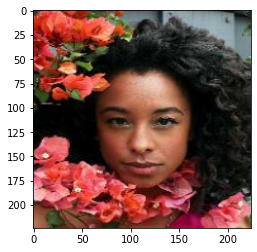

In [16]:
attributes=df.columns[1:]

print(len(attributes[y[0]>0]))
plt.imshow(x[0])

In [17]:
yy=model(x)
print(yy)

tf.Tensor(
[[0.65540785 0.8408616  0.7527192  ... 0.824262   0.1377715  0.86356694]
 [0.2961809  0.7532594  0.8418132  ... 0.63839144 0.21238655 0.7314255 ]
 [0.40369377 0.83175856 0.8328899  ... 0.33636317 0.3815531  0.8479052 ]
 ...
 [0.45234492 0.77206194 0.7336139  ... 0.26883486 0.24764796 0.7371877 ]
 [0.27329883 0.674696   0.8187513  ... 0.4513054  0.17248572 0.6935742 ]
 [0.45358253 0.76223737 0.7407689  ... 0.61802936 0.12010275 0.6603804 ]], shape=(256, 40), dtype=float32)


In [ ]:
model.fit(train_dataset,epochs=EPOCHS,steps_per_epoch=ts,callbacks=callbacks,validation_data=val_dataset,validation_steps=vs)

Epoch 1/50
541/541 [==============================] - 1474s 3s/step - loss: 0.7697 - binary_accuracy: 0.5314 - val_loss: 0.6894 - val_binary_accuracy: 0.5888
INFO:tensorflow:Assets written to: models/attributeclassifier/assets
Epoch 2/50
541/541 [==============================] - 833s 2s/step - loss: 0.6615 - binary_accuracy: 0.6107 - val_loss: 0.5957 - val_binary_accuracy: 0.6718
INFO:tensorflow:Assets written to: models/attributeclassifier/assets
Epoch 3/50
541/541 [==============================] - 904s 2s/step - loss: 0.5752 - binary_accuracy: 0.6922 - val_loss: 0.5297 - val_binary_accuracy: 0.7413
INFO:tensorflow:Assets written to: models/attributeclassifier/assets
Epoch 4/50
541/541 [==============================] - 950s 2s/step - loss: 0.5164 - binary_accuracy: 0.7545 - val_loss: 0.4876 - val_binary_accuracy: 0.7834
INFO:tensorflow:Assets written to: models/attributeclassifier/assets
Epoch 5/50
541/541 [==============================] - 901s 2s/step - loss: 0.4795 - binary_accu

In [ ]:
np.sum(y)

In [ ]:
256*40